# under construction

## Some examples using the tools in this distribution.

### Contents

- Load an image, and downsample to a size appropriate for the machine speed.
- Synthetic images.
- Point operations (lookup tables)
- histogram Modification/matching
- Convolution routines
- Compare speed of convolution/downsampling routines
- Display image and extension of left and top boundaries
- Multi-scale pyramids (see TUTORIALS/01_pyramids.ipynb)
    - A Laplacian pyramid
    - Wavelet/QMF pyramids
    - Steerable pyramid
    - Steerable pyramid, constructed in frequency domain

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyrtools as pt

%load_ext autoreload
%autoreload 2

## Load an image, and downsample to a size appropriate for the machine speed

In [2]:
oim = plt.imread('../DATA/einsteinCorrect.pgm').astype(float)

In [3]:
import time
t = time.time()
pt.corrDn(oim, filt=np.ones((2,2)) / 4, edges='reflect1', step=(2, 2), start=(0, 0), stop=None)
elapsed = time.time() - t

In [4]:
imSubSample = min(max(np.floor(np.log2(elapsed)/2+3),0),2)
# imSubSample = 1

In [5]:
im = pt.blurDn(oim, n_levels=imSubSample, filt='qmf9')

ShowIm: 3 types of automatic graylevel scaling, 2 types of automatic sizing, with or without title and Range information.

In [6]:
? pt.imshow

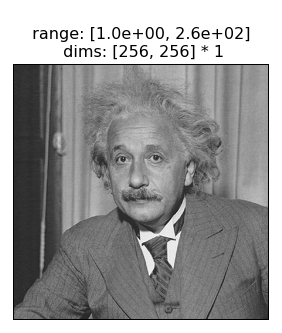

In [7]:
pt.imshow(im);

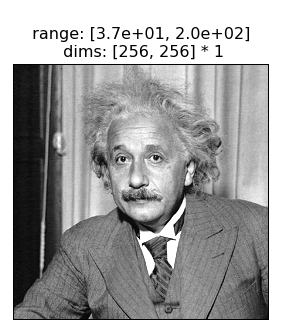

In [8]:
pt.imshow(im, vrange='auto2');
# TODO
# pt.imshow([oim,im], zoom=[1,2], title=['original', 'subsampled'], vrange='auto2', col_wrap=2);

In [9]:
# TODO
# plt.figure(figsize=(15,15))
# ax1 = plt.subplot(1,2,1)
# ax2 = plt.subplot(1,2,2)
# pt.imshow(im, ax= ax1)
# pt.imshow(oim, ax= ax2);

## Statistics:

In [10]:
pt.imStats(im)
pt.imCompare(im, oim)

Image statistics:
  Range: [1.000000, 255.000000]
  Mean: 116.456772,  Stdev: 39.899688,  Kurtosis: 3.433610
Difference statistics:
  Range: [0, 0]
  Mean: 0.000000,  Stdev (rmse): 0.000000,  SNR (dB): inf


## Synthetic images

In [11]:
# pick some parameters
size      = 256
direction = 2 * np.pi * np.random.rand(1)
slope     = 10 * np.random.rand(1) - 5
intercept = 10 * np.random.rand(1) - 5
origin    = np.round(size * np.random.rand(2,1)).astype(int)
exponent  = 0.8 + np.random.rand(1)
amplitude = 1 + 5 * np.random.rand(1)
phase     = 2 * np.pi * np.random.rand(1)
period    = 20
twidth    = 7

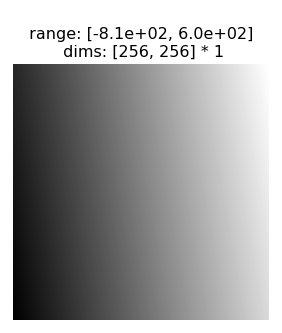

In [12]:
pt.imshow(pt.mkRamp(size, direction, slope, intercept, origin));

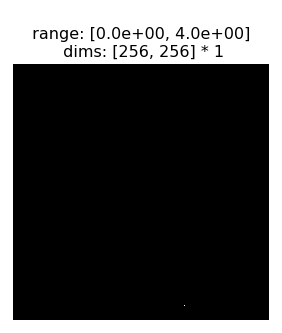

In [13]:
pt.imshow(pt.mkImpulse(size, origin, amplitude));

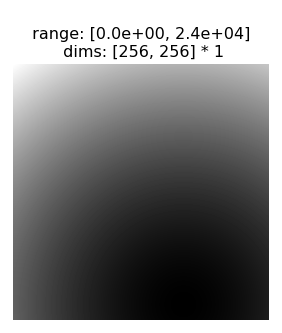

In [14]:
pt.imshow(pt.mkR(size, exponent, origin));

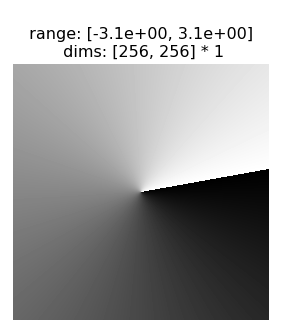

In [15]:
pt.imshow(pt.mkAngle(size, direction));

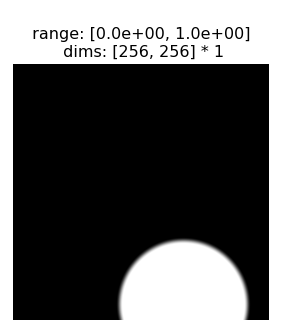

In [16]:
pt.imshow(pt.mkDisc(size, size/4, origin, twidth));

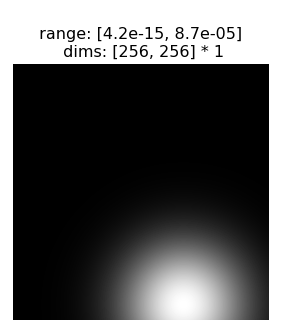

In [17]:
pt.imshow(pt.mkGaussian(size, (size/6)**2, origin, 'norm'));

In [18]:
# TODO fix normalization - range
g = pt.mkGaussian(size, (size/6)**2, origin, 'norm')
g.min(), g.max()

(4.204388276966708e-15, 8.742642137616321e-05)

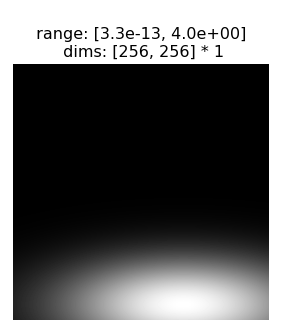

In [19]:
pt.imshow(pt.mkGaussian(size, ((size/8)**2,(size/3)**2), origin, amplitude));

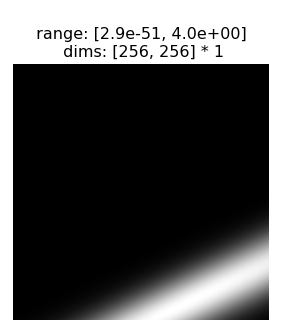

In [20]:
# cov = (size * np.random.uniform(-1,1,(2,2)))
# cov = cov.dot(cov.T)
# print(np.round(cov))
cov = np.array((( 12571., -25233.),
                (-25233.,  52488.)))

pt.imshow(pt.mkGaussian(size, cov, origin, amplitude));

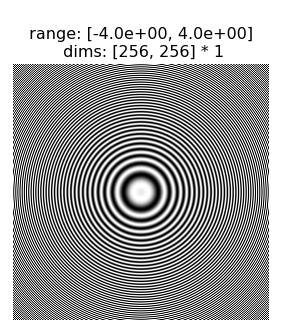

In [21]:
pt.imshow(pt.mkZonePlate(size, amplitude, phase));

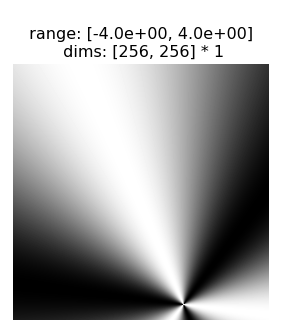

In [22]:
pt.imshow(pt.mkAngularSine(size, 3, amplitude, phase, origin));

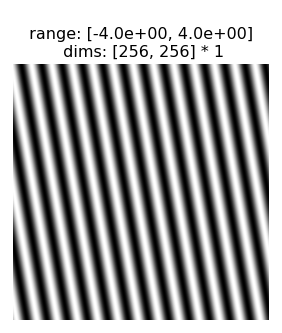

In [23]:
pt.imshow(pt.mkSine(size, period, direction, amplitude=amplitude, phase=phase, origin=origin));

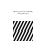

In [24]:
pt.imshow(pt.mkSine(20, frequency=[1,2]));

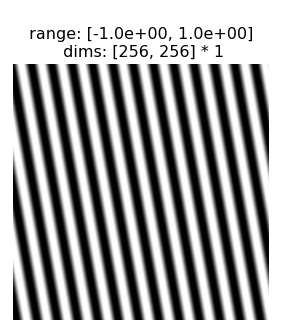

In [25]:
pt.imshow(pt.mkSquare(size, period, direction, amplitude, phase=phase, origin=origin, twidth=twidth));

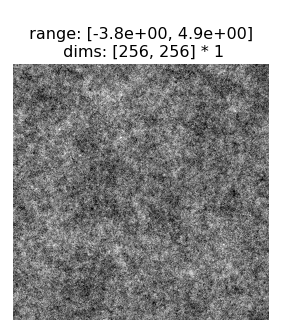

In [26]:
pt.imshow(pt.mkFract(size, exponent));

## Point operations (lookup tables):

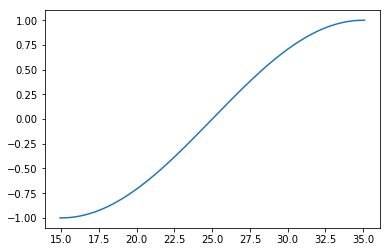

In [27]:
Xtbl,Ytbl = pt.rcosFn(width=20, position=25, values=(-1, 1))
plt.plot(Xtbl,Ytbl)
plt.show()

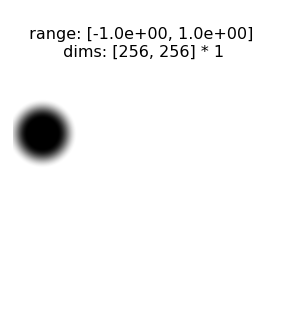

In [28]:
pt.imshow(pt.pointOp(pt.mkR(size,1,[70,30]), Ytbl, Xtbl[0], Xtbl[1]-Xtbl[0], 0));

## histogram Modification/matching:

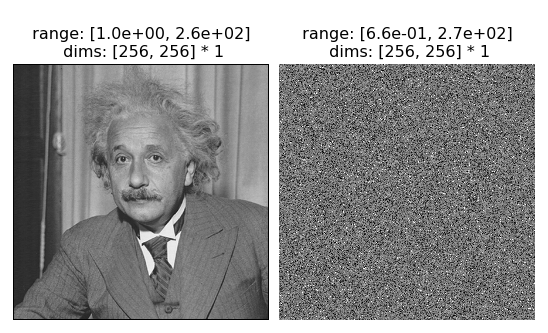

In [29]:
N, X    = pt.matlab_histo(im, nbins=150)
mn, mx  = pt.range2(im)

matched = pt.histoMatch(np.random.uniform(size=im.shape), N, X)

pt.imshow([im,matched]);

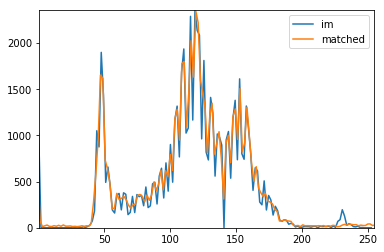

In [30]:
Nm, Xm = pt.matlab_histo(matched,nbins=150)

plt.figure()
plt.plot(X.flatten()[:-1],N.flatten())
plt.plot(Xm.flatten()[:-1],Nm.flatten())
plt.xlim([mn, mx])
plt.ylim([0, np.max(N)])
plt.legend(['im','matched'])
plt.show()

In [31]:
# TODO 
# fix error in histoMatch

## Convolution routines: Compare speed of convolution/downsampling routines

In [32]:
k = 5
size = 2 ** 9
noise = np.random.rand(size,size)
filt  = np.random.rand(k,k)

In [33]:
%%time
res1 = pt.corrDn(noise, np.flipud(np.fliplr(filt)), 'reflect1', step=[2, 2])

CPU times: user 6.19 ms, sys: 4.25 ms, total: 10.4 ms
Wall time: 8.92 ms


In [34]:
%%time
ires = pt.rconv2(noise,filt)
res2 = ires[0:size:2,0:size:2]

CPU times: user 36.7 ms, sys: 21.4 ms, total: 58.1 ms
Wall time: 57.1 ms


In [35]:
pt.imCompare(res1, res2)

Difference statistics:
  Range: [0, 0]
  Mean: -0.000000,  Stdev (rmse): 0.000000,  SNR (dB): 287.340837


In [36]:
res3 = pt.corrDn(noise, np.flipud(np.fliplr(filt)), 'reflect1', step=[1, 1])
pt.imCompare(res3, ires)

Difference statistics:
  Range: [0, 0]
  Mean: -0.000000,  Stdev (rmse): 0.000000,  SNR (dB): 287.385740


In [37]:
im = plt.imread('../DATA/einsteinCorrect.pgm').astype(float)
# im = pt.mkImpulse(256, origin=None)

In [38]:
binom5 = pt.binomialFilter(5)
# construct a separable 2D filter
lo_filt = 2*binom5*binom5.T   

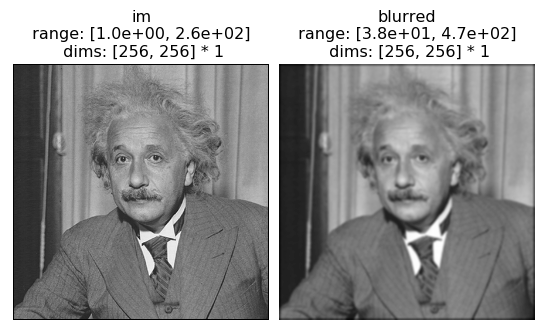

In [39]:
blurred = pt.rconv2(im, lo_filt) 
pt.imshow([im, blurred], title=['im', 'blurred']);

In [40]:
# much faster implementation:
b = pt.corrDn(im, np.flipud(np.fliplr(lo_filt)), 'reflect1', step=[1, 1])
pt.imCompare(blurred, b)

# each dimension separately
bx  = pt.corrDn(im, binom5.T, 'reflect1')
bxy = pt.corrDn(bx, binom5, 'reflect1')
bxy *= 2
pt.imCompare(bxy, b)

Difference statistics:
  Range: [0, 0]
  Mean: 0.000000,  Stdev (rmse): 0.000000,  SNR (dB): 294.102114
Difference statistics:
  Range: [0, 0]
  Mean: 0.000000,  Stdev (rmse): 0.000000,  SNR (dB): inf


In [41]:
# TODO explain the source of these small differences

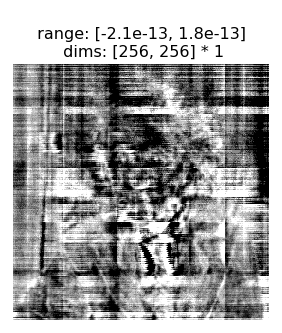

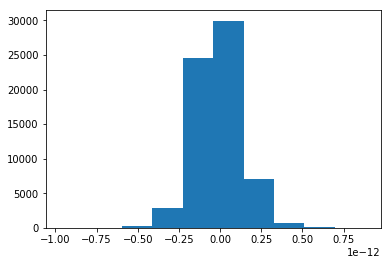

In [42]:
diff = b-blurred
pt.imshow(diff, vrange='auto3');
plt.figure()
plt.hist(diff.flatten())
plt.show()

Difference statistics:
  Range: [0, 0]
  Mean: 0.000000,  Stdev (rmse): 0.000000,  SNR (dB): inf


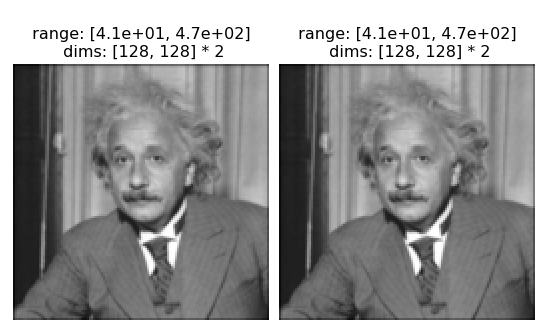

In [43]:
# blur and downsample in a single step
blurred1 = pt.corrDn(image = im, filt = lo_filt, step = (2,2))

bx  = pt.corrDn(im, binom5.T, 'reflect1', step=[1, 2])
bxy = pt.corrDn(bx, binom5, 'reflect1', step=[2, 1])
bxy *= 2

pt.imshow([blurred1, bxy], zoom=2);
pt.imCompare(blurred1, bxy)

In [44]:
# TODO
# compare directly to to scipy.signal?

import scipy.signal as sps

res4 = sps.convolve2d(noise, filt, mode='same', boundary='symm')

pt.imCompare(res4, ires)

Difference statistics:
  Range: [-2, 1]
  Mean: 0.000065,  Stdev (rmse): 0.074440,  SNR (dB): 21.346232


## Display image and extension of left and top boundaries:

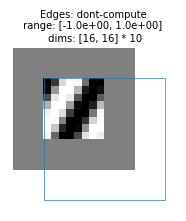

In [45]:
fsz = [9, 9]
fmid = np.ceil((fsz[0]+1)/2)
imsz = (16, 16)

# pick one:
im = np.eye(imsz[0])
im = pt.mkRamp(imsz, np.pi/6)
im = pt.mkSquare(imsz, 6, np.pi/6)

# pick one:
edges='reflect1'
edges='reflect2'
edges='repeat'
edges='extend'
edges='zero'
edges='circular'
edges='dont-compute'

filt = pt.mkImpulse(fsz,[0, 0])
pt.imshow(pt.corrDn(im,filt,edges), zoom=10, title='Edges: ' + str(edges))
# TODO
plt.plot([0,0,imsz[1],imsz[1],0]+fmid-1.5,
         [0,imsz[0],imsz[0],0,0]+fmid-1.5, lw=.5)
plt.show()

## Pyramids

In [46]:
im = oim

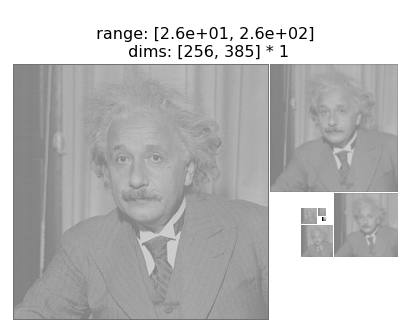

In [47]:
pyr = pt.GaussianPyramid(im) 
pyr.showPyr()
# pyr.reconPyr() # would throw error on purpose..

Difference statistics:
  Range: [0, 0]
  Mean: 0.000000,  Stdev (rmse): 0.000000,  SNR (dB): inf


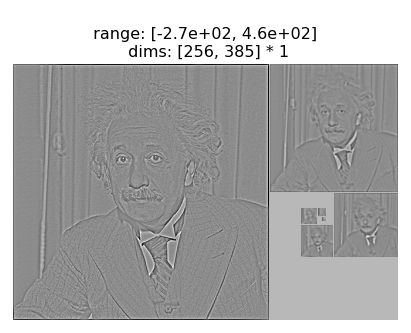

In [48]:
pyr = pt.LaplacianPyramid(im)
pyr.showPyr()
res = pyr.reconPyr()
pt.imCompare(im,res)

Difference statistics:
  Range: [0, 0]
  Mean: -0.194466,  Stdev (rmse): 0.085144,  SNR (dB): 53.416318


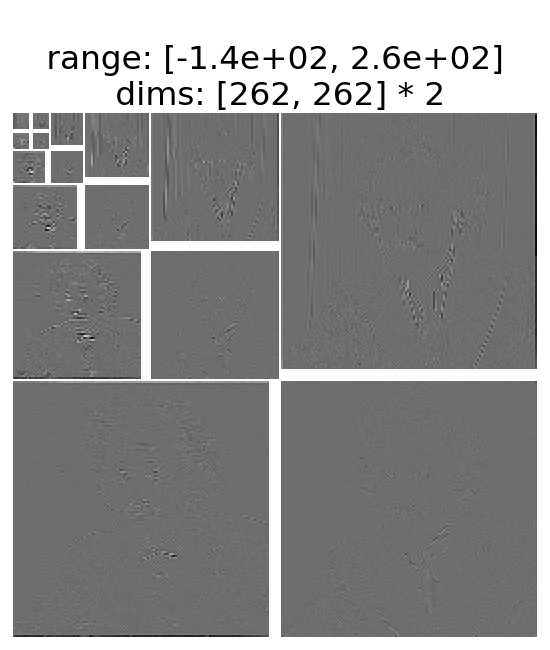

In [49]:
pyr = pt.WaveletPyramid(im)
pyr.showPyr()
res = pyr.reconPyr()
pt.imCompare(im,res)

Difference statistics:
  Range: [-116, 35]
  Mean: -1.152866,  Stdev (rmse): 8.760636,  SNR (dB): 13.168677


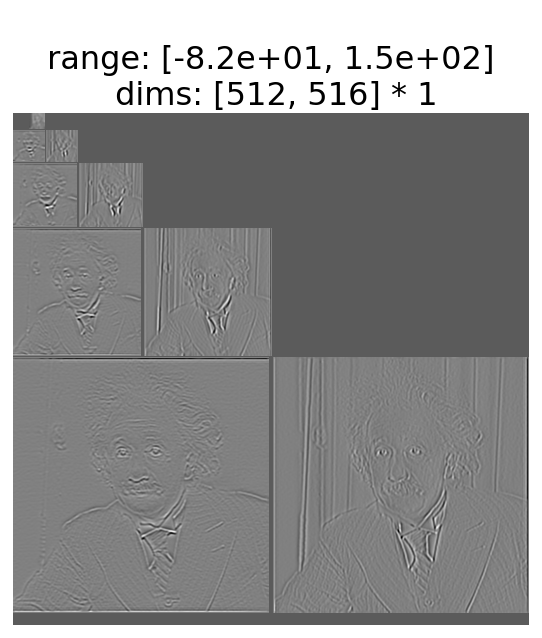

In [52]:
pyr = pt.SteerablePyramidSpace(im)
pyr.showPyr()
res = pyr.reconPyr()
pt.imCompare(im,res)

In [53]:
# TODO
# error with some filters: 242 index 2 is out of bounds
# pyr = pt.Spyr(im, filter='sp3Filters')
# pyr.showPyr()
# res = pyr.reconPyr()
# pt.imCompare(im,res)

Difference statistics:
  Range: [0, 0]
  Mean: 0.000000,  Stdev (rmse): 0.000269,  SNR (dB): 103.419646


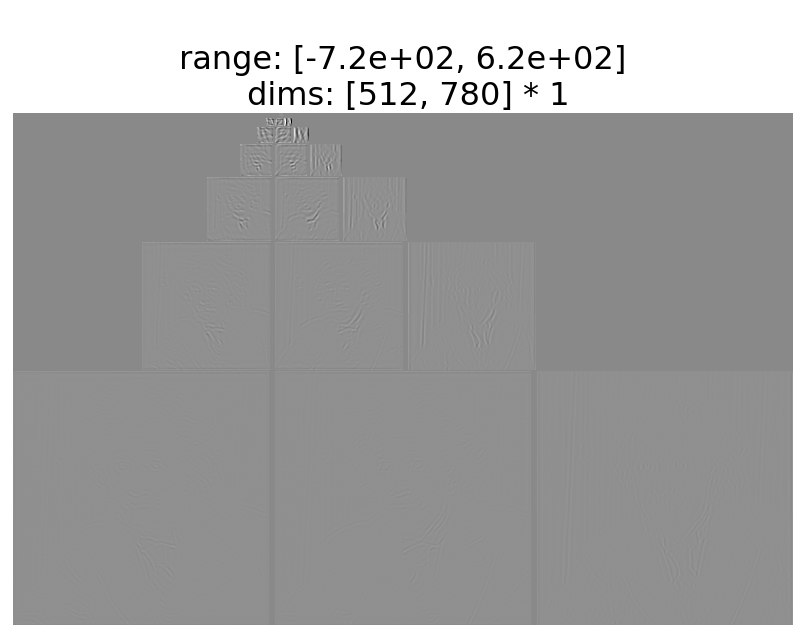

In [55]:
pyr = pt.SteerablePyramidFreq(im, order=2) #, height=2, order=2
pyr.showPyr()
res = pyr.reconPyr()
pt.imCompare(im,res)

In [ ]:
# TODO
# 392 Casting complex values to real discards the imaginary part
# pyr = pt.SCFpyr(im)
# pyr.showPyr()
# res = pyr.reconPyr()
# pt.imCompare(im,res)

In [ ]:
# TODO
# decide what range is printed in title
# pyr.showPyr()
# pyr.showPyr(prange='indep1')
# pyr.showPyr(prange='indep2')